**Визначення стадії хвороби Альцгеймера на основі знімків МРТ**

Хвороба Альцгеймера - це нейродегенеративне захворювання, яке повільно прогресує та поступово руйнує клітини мозку. Ця хвороба є найпоширенішою формою деменції, на яку припадає 60-65% випадків з усіх видів деменції. Це захворювання впливає на пам'ять і когнітивні навички людини, що призводить до затьмарення свідомості, змін настрою й дезорієнтації в просторі та часі. 

Дані для виконання завдання взято із платформи Kaggle.\
Посилання на датасет - https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images

Підключимось до Kaggle через Google Colab.

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

Завантажимо потрібний датасет із Kaggle.

In [7]:
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 79% 27.0M/34.1M [00:00<00:00, 103MB/s] 
100% 34.1M/34.1M [00:00<00:00, 135MB/s]


Розпакуємо архів із даними.

In [ ]:
!echo "no"| unzip alzheimers-dataset-4-class-of-images.zip -d ./

Імпортуємо бібліотеки.

In [ ]:
!pip install -U tensorflow-addons

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

Дані розміщені в папці Alzheimer's Dataset.

В ній є 2 папки train та test, кожна з яких містить по 4 папки із зображеннями.\
NonDemented представляє собою знімки МРТ, які мають ознаки доклінічної стадії хвороби.\
VeryMildDemented містить знімки, що мають ознаки ранньої стадії хвороби Альцгеймера.\
MildDemented вказує на наявність симптомів помірної стадії хвороби.\
ModerateDemented визначає знімки, на яких присутні ознаки важкої стадії хвороби.

Об'єднаємо дані із папок train та test і запишемо їх у папку dataset.

In [ ]:
if os.path.exists("./dataset/"):
    remove_tree("./dataset/")
    

os.mkdir("./dataset/")
copy_tree('./Alzheimer_s Dataset/train', "./dataset/")
copy_tree('./Alzheimer_s Dataset/test', "./dataset/")

Розмір зображень в датасеті дорівнює 100x100.

In [12]:
IMG_SIZE = 100
IMAGE_SIZE = [IMG_SIZE, IMG_SIZE]

In [19]:
work_dr = IDG(rescale = 1./255, brightness_range=[0.8, 1.2], zoom_range=[.99, 1.01], data_format="channels_last", fill_mode="constant", horizontal_flip=True)

train_data_gen = work_dr.flow_from_directory(directory='./dataset/', target_size=(IMG_SIZE, IMG_SIZE), batch_size=6500, shuffle=True)

Found 6400 images belonging to 4 classes.


In [20]:
train_data, train_labels = train_data_gen.next()

Розбиття набору даних на тренувальний та тестовий у співвідношенні 9:1.

In [21]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.1, random_state=42)

Всього представлено:
*   3200 знімків МРТ, де виявлено ознаки доклінічної стадії хвороби Альцгеймера (NonDemented);
*   2240 знімків МРТ, на яких присутні ознаки ранньої стадії хвороби (VeryMildDemented);
*   896 знімків МРТ, де є ознаки помірної стадії хвороби Альцгеймера (MildDemented);
*   64 знімки МРТ, на яких є ознаки важкої стадії хвороби Альцгеймера (ModerateDemented).




Тому для того, щоб алгоритм не ігнорував клас меншості, використаємо техніку oversampling. Випадковим чином будемо обирати знімки із класу меншості із доповненням навчальних даних декількома копіями цього екземпляра. Для цього використаємо модуль SMOTE із бібліотеки imblearn. 

Для тренувального набору даних:

In [22]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [23]:
print("Кількість тренувальних прикладів дорівнює", train_labels.shape[0])

Кількість тренувальних прикладів дорівнює 11524


Для тестового набору даних:

In [24]:
test_data, test_labels = sm.fit_resample(test_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), test_labels)

test_data = test_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [25]:
print("Кількість тестових прикладів дорівнює", test_labels.shape[0])

Кількість тестових прикладів дорівнює 1276


Побудова моделі згорткової нейронної мережі:

In [26]:
def construct_model():
    
    # створення моделі
    model = Sequential()
    # вхідний шар
    model.add(Input(shape=(*IMAGE_SIZE, 3)))
    # перший шар згортки
    model.add(Conv2D(16, 3, activation='relu', padding='same'))
    # другий шар згортки
    model.add(Conv2D(16, 3, activation='relu', padding='same'))
    # перший шар субдискретизації
    model.add(MaxPool2D())
    # третій шар згортки
    model.add(Conv2D(32, 3, activation='relu', padding='same'))
    # четвертий шар згортки
    model.add(Conv2D(32, 3, activation='relu', padding='same'))
    # перший шар нормалізації
    model.add(BatchNormalization())
    # другий шар субдискретизації
    model.add(MaxPool2D())
    # п'ятий шар згортки
    model.add(Conv2D(64, 3, activation='relu', padding='same'))
    # шостий шар згортки
    model.add(Conv2D(64, 3, activation='relu', padding='same')) 
    # другий шар нормалізації
    model.add(BatchNormalization())
    # третій шар субдискретизації
    model.add(MaxPool2D())
    # сьомий шар згортки
    model.add(Conv2D(128, 3, activation='relu', padding='same'))
    # восьмий шар згортки
    model.add(Conv2D(128, 3, activation='relu', padding='same'))
    # третій шар нормалізації
    model.add(BatchNormalization())
    # четвертий шар субдискретизації
    model.add(MaxPool2D())
    # перший шар Dropout
    model.add(Dropout(0.2))
    # дев'ятий шар згортки
    model.add(Conv2D(256, 3, activation='relu', padding='same'))
    # десятий шар згортки
    model.add(Conv2D(256, 3, activation='relu', padding='same'))
    # четвертий шар нормалізації
    model.add(BatchNormalization())
    # п'ятий шар субдискретизації
    model.add(MaxPool2D())
    # другий шар Dropout
    model.add(Dropout(0.2))
    # шар Flatten
    model.add(Flatten())
    # вихідний шар
    model.add(Dense(4, activation='softmax'))

    return model

In [27]:
model = construct_model()

In [28]:
# оптимізаційні параметри
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

Тренування моделі:

In [29]:
EPOCHS = 50

history = model.fit(train_data, train_labels, epochs=EPOCHS, verbose=2)

Epoch 1/50
361/361 - 29s - loss: 1.1776 - accuracy: 0.5488 - 29s/epoch - 79ms/step
Epoch 2/50
361/361 - 15s - loss: 0.6801 - accuracy: 0.6937 - 15s/epoch - 42ms/step
Epoch 3/50
361/361 - 15s - loss: 0.5249 - accuracy: 0.7647 - 15s/epoch - 43ms/step
Epoch 4/50
361/361 - 15s - loss: 0.4328 - accuracy: 0.8130 - 15s/epoch - 42ms/step
Epoch 5/50
361/361 - 15s - loss: 0.3167 - accuracy: 0.8632 - 15s/epoch - 42ms/step
Epoch 6/50
361/361 - 15s - loss: 0.3229 - accuracy: 0.8690 - 15s/epoch - 43ms/step
Epoch 7/50
361/361 - 15s - loss: 0.2232 - accuracy: 0.9122 - 15s/epoch - 42ms/step
Epoch 8/50
361/361 - 15s - loss: 0.1584 - accuracy: 0.9393 - 15s/epoch - 43ms/step
Epoch 9/50
361/361 - 15s - loss: 0.1341 - accuracy: 0.9488 - 15s/epoch - 43ms/step
Epoch 10/50
361/361 - 16s - loss: 0.1097 - accuracy: 0.9595 - 16s/epoch - 44ms/step
Epoch 11/50
361/361 - 16s - loss: 0.1078 - accuracy: 0.9603 - 16s/epoch - 43ms/step
Epoch 12/50
361/361 - 15s - loss: 0.0962 - accuracy: 0.9647 - 15s/epoch - 43ms/step
E

Визначимо оцінку якості тренування моделі на тестових даних:

In [30]:
scores = model.evaluate(test_data, test_labels, verbose=0)

In [31]:
print("Testing Accuracy: %.2f%%"%(scores[1] * 100))

Testing Accuracy: 88.95%


Виведемо матрицю, що визначає співвідношення між реальним результатом для тестових даних та результатом розпізнавання зображень навченої моделі.

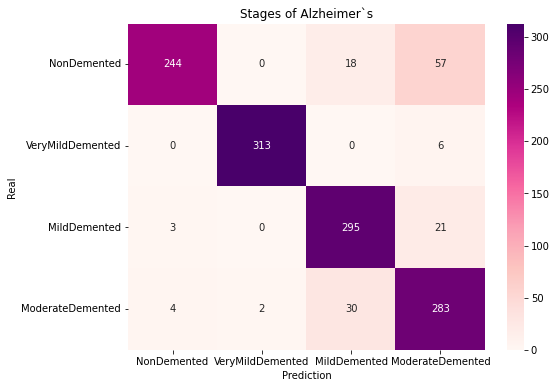

In [32]:
pred_ls = np.argmax(model.predict(test_data), axis=1)
test_ls = np.argmax(test_labels, axis=1)

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']


plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k')

ax = seaborn.heatmap(confusion_matrix(test_ls, pred_ls), cmap='RdPu', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Stages of Alzheimer`s')
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.show(ax)

Для доклінічної стадії (NonDemented):
*   244 знімки було розпізнано правильно;
*   75 змнімків було розпізнано неправильно, з них 18 віднесено до стадії помірної деменції (MildDemented), а 57 до стадії важкої деменції (ModerateDemented). 

Для ранньої стадії (VeryMildDemented):
*   313 знімків було розпізнано правильно;
*   6 знімків було розпізнано неправильно, вони були віднесені до стадії важкої деменції (ModerateDemented). 

Для стадії помірної деменції (MildDemented):
*   295 знімків було розпізнано правильно;
*   24 знімки було розпізнано неправильно, з них 3 віднесено до доклінічної стадії (NonDemented), а 21 до стадії важкої деменції (ModerateDemented).

Для стадії важкої деменції (ModerateDemented):
*   283 знімки було розпізнано правильно;
*   36 знімків було розпізнано неправильно, з них 4 віднесено до доклінічної стадії (NonDemented), 2 віднесено до ранньої стадії (VeryMildDemented), а 30 до стадії важкої деменції (ModerateDemented).

**Список використаних джерел:**
1.   https://towardsdatascience.com/tagged/alzheimers
2.   https://towardsdatascience.com/alzheimer-diagnosis-with-deep-learning-model-implementation-5a0fd31f148f
3.   https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
4.   https://towardsdatascience.com/understanding-cnn-convolutional-neural-network-69fd626ee7d4
5.  https://www.kaggle.com/fatemehghanadi/alzheimer-4-classes 

